In [1]:
# 04_hierarchical_demo.ipynb (Python Code exportiert als Skript zur Vorlage)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from planners.visibility_prm import VisibilityPRM
from planners.hierarchical_planner import HierarchicalPlanner
from planners.lazy_prm import LazyPRM
from planners.basic_prm import BasicPRM
from utils.visibility_prm_visualize import visibility_prm_visualize
from utils.hierarchical_visualize import visualize_hierarchical_planning
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes
import time
import pandas as pd
from scipy.spatial.distance import euclidean

In [2]:
# ---- Konfiguration für den globalen Planer (VisibilityPRM) ----
config_high = {
    "ntry": 50
}

config_low_lazy = {
    "initialRoadmapSize": 50,
    "updateRoadmapSize": 10,
    "kNearest": 8,
    "maxIterations": 10
}

config_low_basic = {
    "numNodes": 50,
    "radius": 4
}

scenes = get_all_scenes()

In [3]:
import os
import matplotlib.pyplot as plt

# 📁 Ordner für Plots & Ergebnisse
plot_dir = "plots_hierarchical"
results_dir = "benchmark_results"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# ---- Benchmark-Runner ----
def run_benchmark(subplanner_type, config_local):
    results = []
    SubPlanner = LazyPRM if subplanner_type == "Lazy" else BasicPRM
    print(f"\n🔁 Starte Benchmarks mit Subplanner: {subplanner_type}")

    for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
        print(f"\n🔍 Szene: {scene_name}")
        start = [list(start_pos)]
        goal = [list(goal_pos)]

        collision_checker = CollisionChecker(scene, limits)

        planner = HierarchicalPlanner(
            scene=scene,
            limits=limits,
            GlobalPlannerClass=VisibilityPRM,
            LocalPlannerClass=SubPlanner,
            config_global=config_high,
            config_local=config_local
        )

        t0 = time.time()
        path = planner.plan_path(start, goal)
        t1 = time.time()

        coords = planner.get_solution_path() if path else []
        euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

        if not path:
            print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
            result = {
                "planner": f"Hierarchical-{subplanner_type}",
                "scene": scene_name,
                "hasPath": False,
                "length": 0,
                "euclidean_length": 0,
                "time": t1 - t0,
                "nodes": 0,
                "edges": 0,
                "roadmap_size": 0
            }
            results.append(result)
            continue

        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")
        planner.solution_path = path
        planner.graph = planner.global_planner.graph

        # 📸 Visualisierung speichern
        visualize_hierarchical_planning(planner, collision_checker, config_local)
        filename = f"{scene_name}_Hierarchical-{subplanner_type}.png".replace(" ", "_")
        plt.savefig(os.path.join(plot_dir, filename), dpi=300)
        plt.close()

        result = {
            "planner": f"Hierarchical-{subplanner_type}",
            "scene": scene_name,
            "hasPath": True,
            "length": len(path),
            "euclidean_length": euclidean_length,
            "time": t1 - t0,
            "nodes": len(planner.graph.nodes),
            "edges": len(planner.graph.edges),
            "roadmap_size": planner.graph.size()
        }
        results.append(result)

    return results



🔁 Starte Benchmarks mit Subplanner: Lazy

🔍 Szene: U-Shape
Globaler Pfad: ['start', 3, 12, 7, 101, 'goal']
Koordinaten des globalen Pfads: [[2.0, 20.0], array([ 0.33717164, 14.20271261]), array([5.90377089, 2.93039816]), array([9.32903599, 3.65329078]), array([20.282538  ,  2.02032228]), [20.0, 2.0]]
Segment 0: [2.0, 20.0] → [ 0.33717164 14.20271261]
→ Lokaler Planner für Segment 0: [2.0, 20.0] → [ 0.33717164 14.20271261]
   Lokale Begrenzung (geclipped): ((0, np.float64(7.199633753374014)), (np.float64(11.070308371645954), 22))
Segment 1: [ 0.33717164 14.20271261] → [5.90377089 2.93039816]
→ Lokaler Planner für Segment 1: [ 0.33717164 14.20271261] → [5.90377089 2.93039816]
   Lokale Begrenzung (geclipped): ((0, np.float64(11.120471261468706)), (np.float64(0.5665553875134464), np.float64(16.566555387513446)))
Segment 2: [5.90377089 2.93039816] → [9.32903599 3.65329078]
→ Lokaler Planner für Segment 2: [5.90377089 2.93039816] → [9.32903599 3.65329078]
   Lokale Begrenzung (geclipped): 

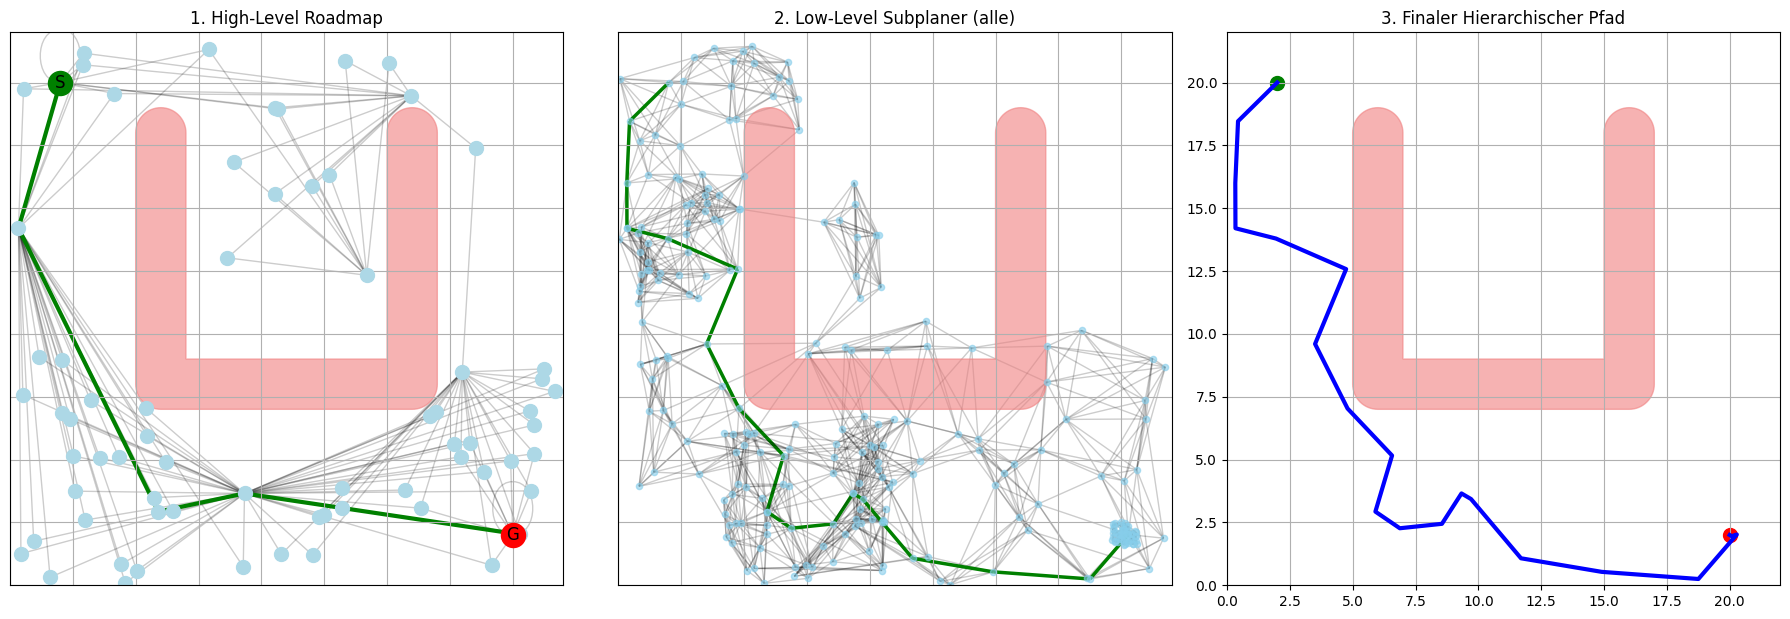


🔍 Szene: L-Shape
Globaler Pfad: ['start', 33, 4, 5, 'goal']
Koordinaten des globalen Pfads: [[2.0, 2.0], array([2.29052251, 1.66202945]), array([ 2.1778925 , 19.01719164]), array([21.96711081, 20.23506936]), [15.0, 15.0]]
Segment 0: [2.0, 2.0] → [2.29052251 1.66202945]
→ Lokaler Planner für Segment 0: [2.0, 2.0] → [2.29052251 1.66202945]
   Lokale Begrenzung (geclipped): ((np.float64(1.6452612531904842), np.float64(2.645261253190484)), (np.float64(1.3310147272137556), np.float64(2.3310147272137556)))
Segment 1: [2.29052251 1.66202945] → [ 2.1778925  19.01719164]
→ Lokaler Planner für Segment 1: [2.29052251 1.66202945] → [ 2.1778925  19.01719164]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.234207502639869)), (np.float64(2.339610545344284), np.float64(18.339610545344286)))
Segment 2: [ 2.1778925  19.01719164] → [21.96711081 20.23506936]
→ Lokaler Planner für Segment 2: [ 2.1778925  19.01719164] → [21.96711081 20.23506936]
   Lokale Begrenzung (geclipped): ((np.float64(4.0725016

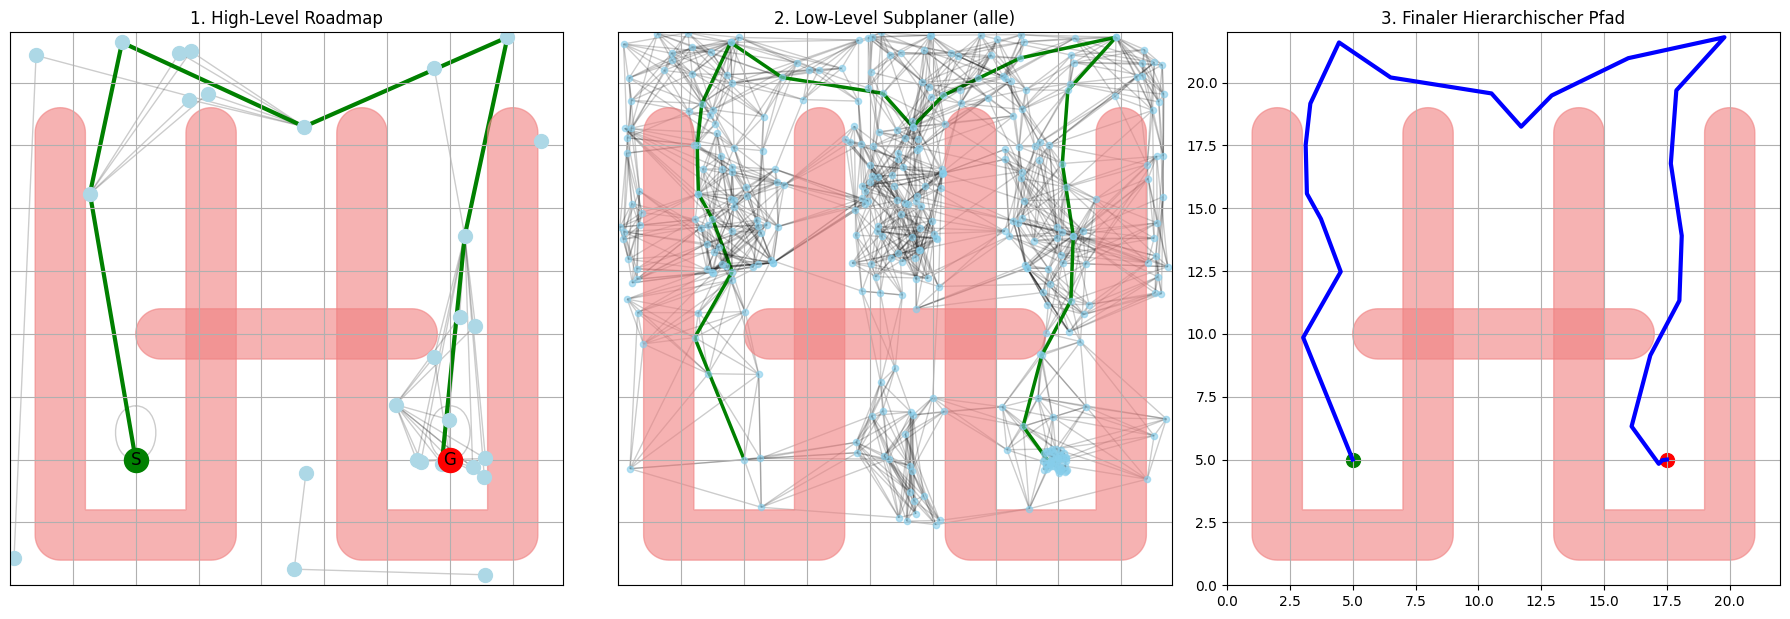


🔍 Szene: Multiple Obstacles
Globaler Pfad: ['start', 36, 6, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([5.17445179, 1.47488665]), array([5.32386527, 9.9465688 ]), [5.0, 21.0]]
Segment 0: [1.0, 1.0] → [5.17445179 1.47488665]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [5.17445179 1.47488665]
   Lokale Begrenzung (geclipped): ((0, np.float64(7.288602459735679)), (0, np.float64(5.438819891976397)))
Segment 1: [5.17445179 1.47488665] → [5.32386527 9.9465688 ]
→ Lokaler Planner für Segment 1: [5.17445179 1.47488665] → [5.32386527 9.9465688 ]
   Lokale Begrenzung (geclipped): ((0, np.float64(13.249158529649428)), (0, np.float64(13.710727723410212)))
❌ Keine lokale Verbindung zwischen [5.17445179 1.47488665] und [5.32386527 9.9465688 ].
❌ Kein Pfad gefunden in Szene: Multiple Obstacles

🔍 Szene: Crossed Obstacles
Globaler Pfad: ['start', 38, 0, 6, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([0.78183389, 2.87859125]), array([19.34495082,  4.25747423]), array([

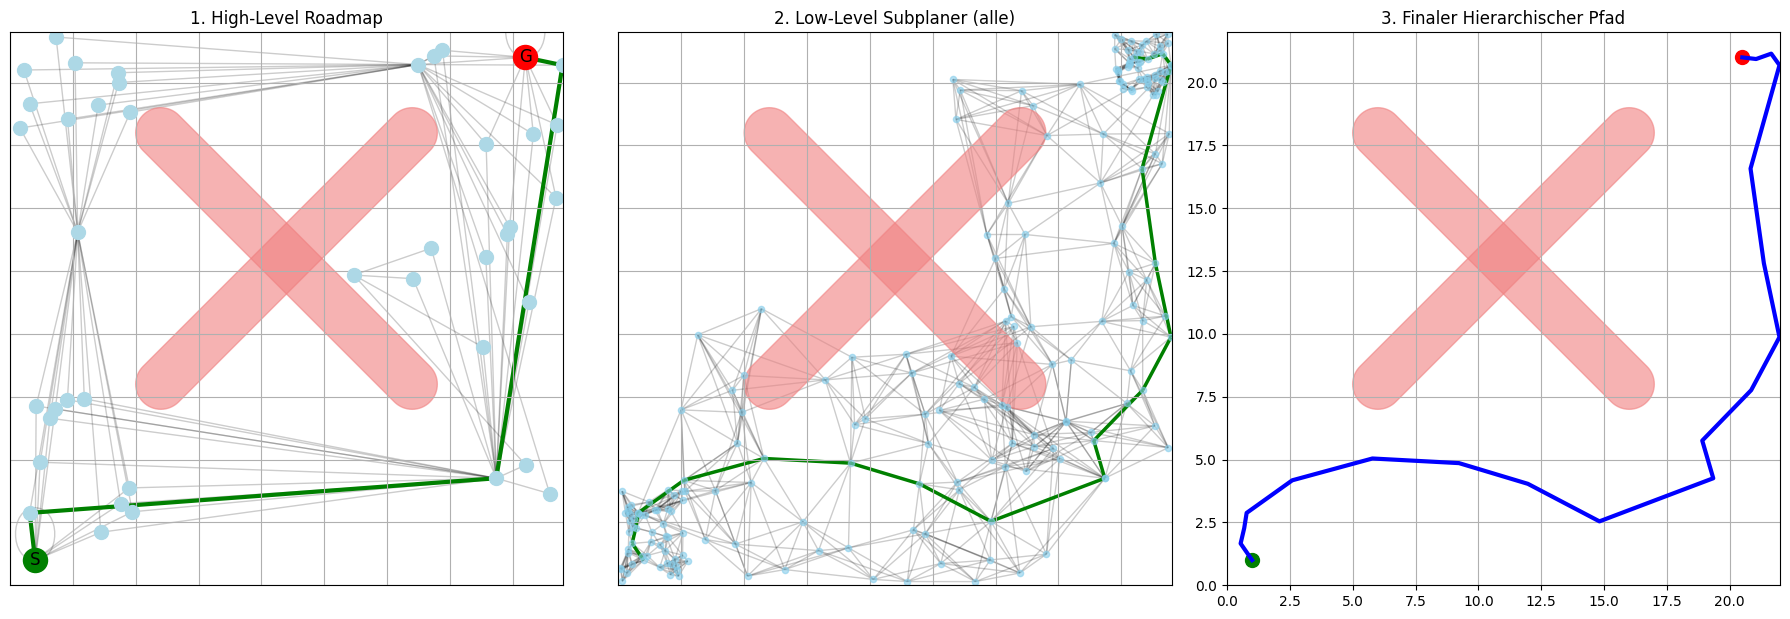


🔍 Szene: Random Obstacles
Globaler Pfad: ['start', 14, 0, 77, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([4.73689997, 8.04014637]), array([ 8.30166856, 15.67225895]), array([18.36095504, 18.87580623]), [19.0, 19.0]]
Segment 0: [1.0, 1.0] → [4.73689997 8.04014637]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [4.73689997 8.04014637]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.838900553664253)), (0, np.float64(12.490523753186453)))
Segment 1: [4.73689997 8.04014637] → [ 8.30166856 15.67225895]
→ Lokaler Planner für Segment 1: [4.73689997 8.04014637] → [ 8.30166856 15.67225895]
   Lokale Begrenzung (geclipped): ((0, np.float64(14.51928426360348)), (np.float64(3.856202660797898), np.float64(19.856202660797898)))
Segment 2: [ 8.30166856 15.67225895] → [18.36095504 18.87580623]
→ Lokaler Planner für Segment 2: [ 8.30166856 15.67225895] → [18.36095504 18.87580623]
   Lokale Begrenzung (geclipped): ((np.float64(5.331311796491729), np.float64(21.33131179649173)), (np.f

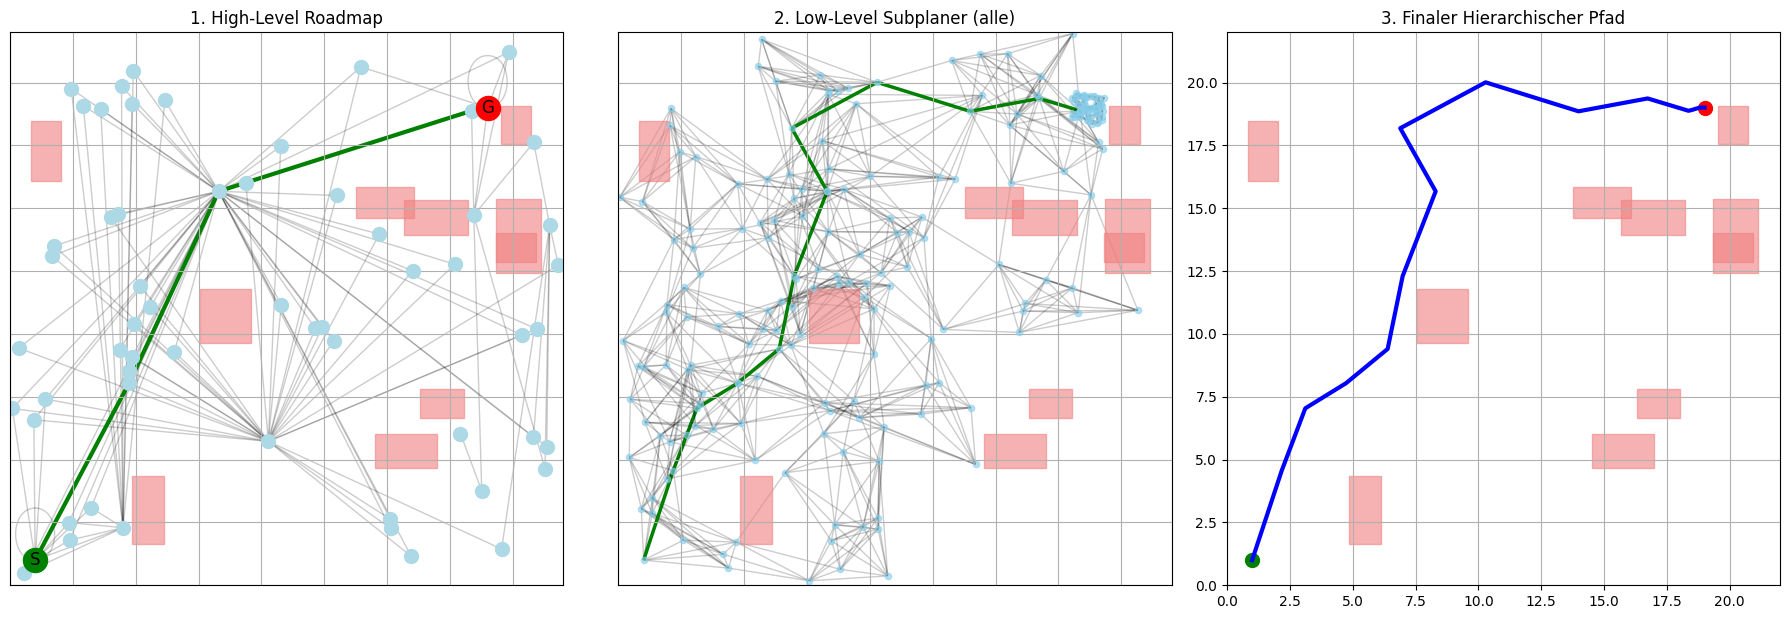


🔁 Starte Benchmarks mit Subplanner: Basic

🔍 Szene: U-Shape
Globaler Pfad: ['start', 54, 3, 45, 'goal']
Koordinaten des globalen Pfads: [[2.0, 20.0], array([ 1.87382133, 20.0017126 ]), array([20.00227838, 21.15895992]), array([19.80609059,  3.9917356 ]), [20.0, 2.0]]
Segment 0: [2.0, 20.0] → [ 1.87382133 20.0017126 ]
→ Lokaler Planner für Segment 0: [2.0, 20.0] → [ 1.87382133 20.0017126 ]
   Lokale Begrenzung (geclipped): ((np.float64(1.4369106663535423), np.float64(2.4369106663535423)), (np.float64(19.500856300631877), np.float64(20.500856300631877)))
Segment 1: [ 1.87382133 20.0017126 ] → [20.00227838 21.15895992]
→ Lokaler Planner für Segment 1: [ 1.87382133 20.0017126 ] → [20.00227838 21.15895992]
   Lokale Begrenzung (geclipped): ((np.float64(2.9380498560636905), np.float64(18.938049856063692)), (np.float64(12.580336262924263), 22))
Segment 2: [20.00227838 21.15895992] → [19.80609059  3.9917356 ]
→ Lokaler Planner für Segment 2: [20.00227838 21.15895992] → [19.80609059  3.9917356

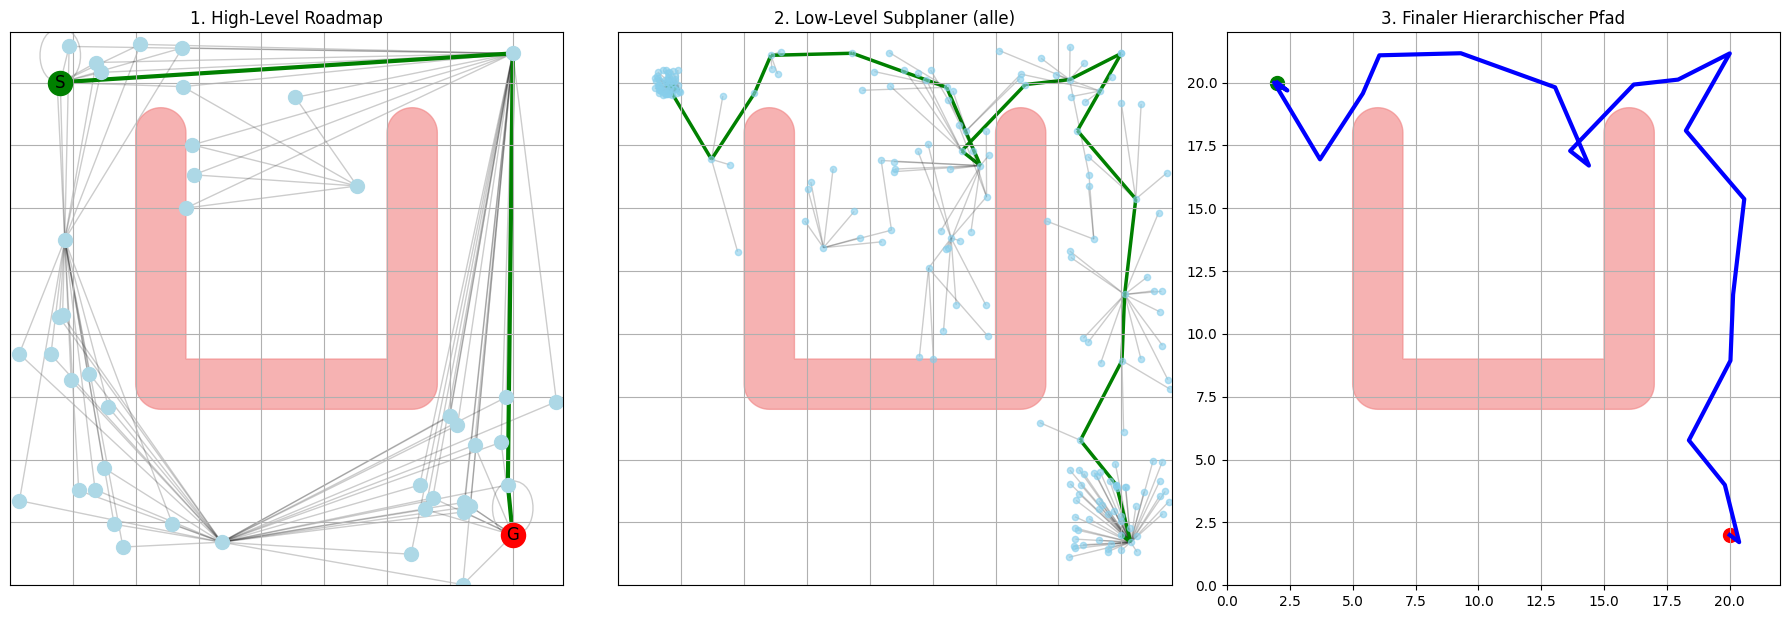


🔍 Szene: L-Shape
Globaler Pfad: ['start', 37, 0, 9, 'goal']
Koordinaten des globalen Pfads: [[2.0, 2.0], array([3.01022724, 0.71963804]), array([16.96792849,  3.48998498]), array([19.10085529, 17.47075456]), [15.0, 15.0]]
Segment 0: [2.0, 2.0] → [3.01022724 0.71963804]
→ Lokaler Planner für Segment 0: [2.0, 2.0] → [3.01022724 0.71963804]
   Lokale Begrenzung (geclipped): ((np.float64(0.8741979789674366), np.float64(4.136029259746638)), (0, np.float64(2.9907346596842306)))
Segment 1: [3.01022724 0.71963804] → [16.96792849  3.48998498]
→ Lokaler Planner für Segment 1: [3.01022724 0.71963804] → [16.96792849  3.48998498]
   Lokale Begrenzung (geclipped): ((np.float64(1.98907786389268), np.float64(17.989077863892682)), (0, np.float64(10.104811507914075)))
Segment 2: [16.96792849  3.48998498] → [19.10085529 17.47075456]
→ Lokaler Planner für Segment 2: [16.96792849  3.48998498] → [19.10085529 17.47075456]
   Lokale Begrenzung (geclipped): ((np.float64(10.034391887247516), 22), (np.float64(2

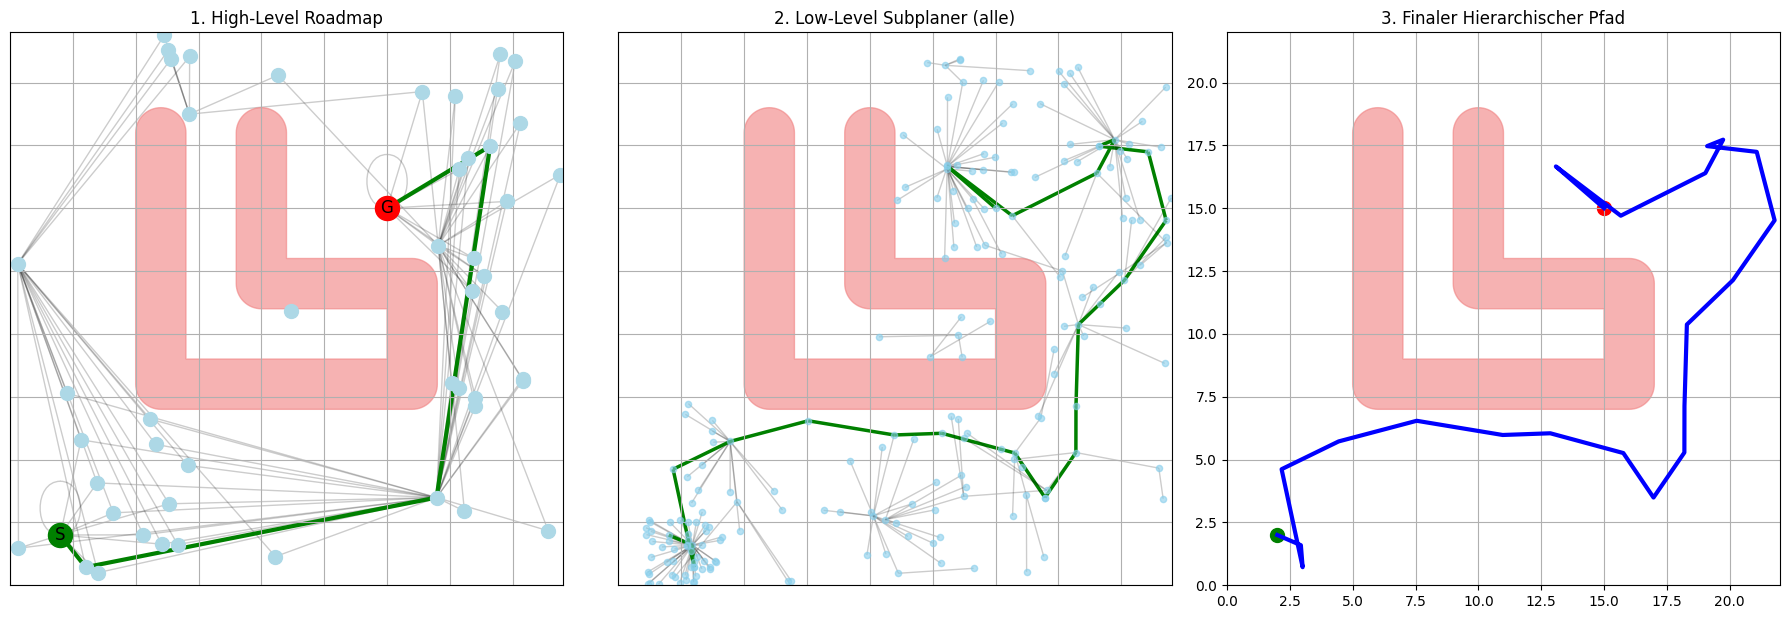


🔍 Szene: Corridor
Kein Pfad im Sichtbarkeitsgraph gefunden.
❌ Kein Pfad gefunden in Szene: Corridor

🔍 Szene: Complex Shape
Globaler Pfad: ['start', 50, 2, 64, 3, 'goal']
Koordinaten des globalen Pfads: [[5.0, 5.0], array([ 4.87120394, 15.52593858]), array([ 1.7911962 , 21.80135576]), array([16.37778815, 18.59843556]), array([17.31323893, 10.83956041]), [17.5, 5.0]]
Segment 0: [5.0, 5.0] → [ 4.87120394 15.52593858]
→ Lokaler Planner für Segment 0: [5.0, 5.0] → [ 4.87120394 15.52593858]
   Lokale Begrenzung (geclipped): ((0, np.float64(12.93560197175915)), (np.float64(2.2629692914763098), np.float64(18.26296929147631)))
Segment 1: [ 4.87120394 15.52593858] → [ 1.7911962  21.80135576]
→ Lokaler Planner für Segment 1: [ 4.87120394 15.52593858] → [ 1.7911962  21.80135576]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.321715677917194)), (np.float64(11.673131563486447), 22))
Segment 2: [ 1.7911962  21.80135576] → [16.37778815 18.59843556]
→ Lokaler Planner für Segment 2: [ 1.7911962 

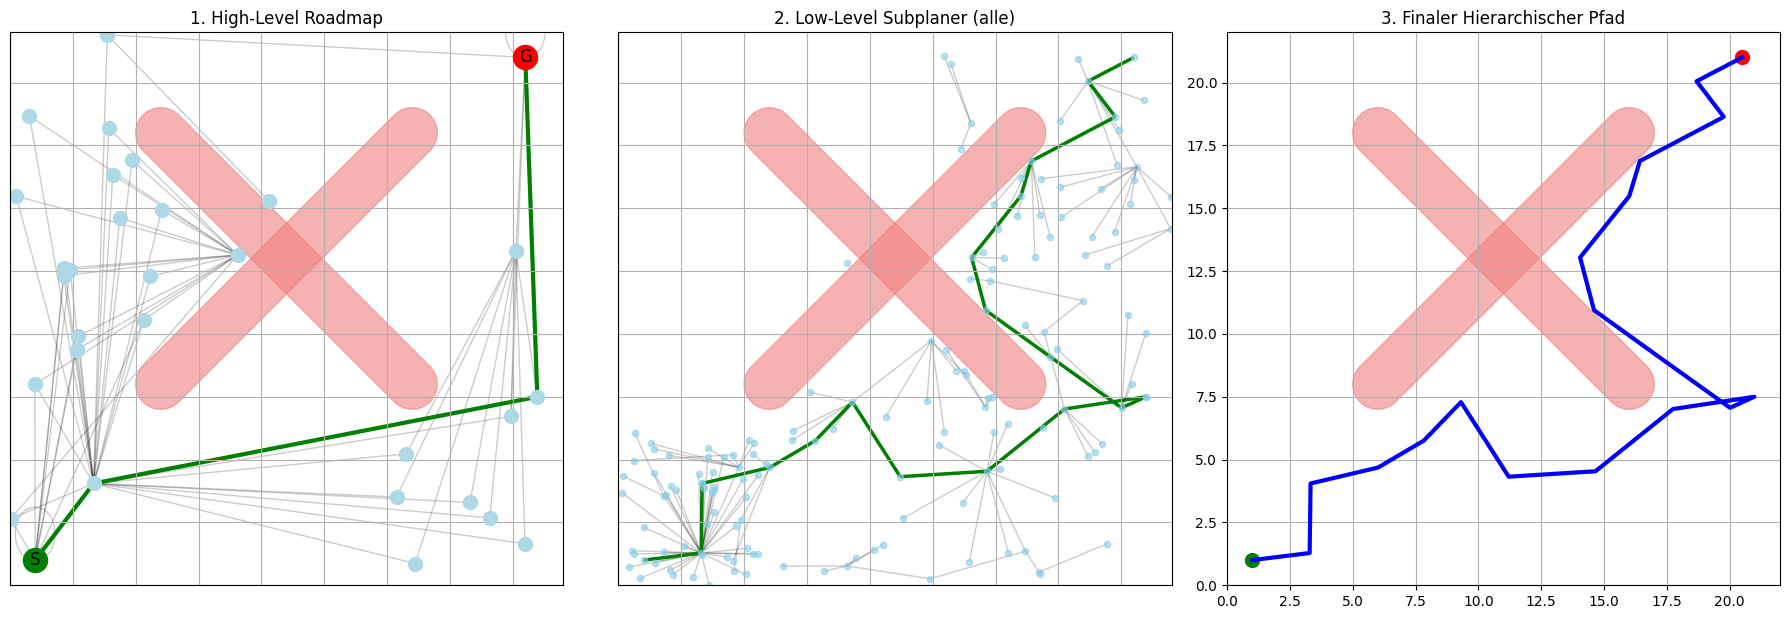


🔍 Szene: Random Obstacles
Globaler Pfad: ['start', 24, 0, 75, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([7.54595117, 0.95726351]), array([ 2.70103899, 20.13174691]), array([17.04550135, 20.91247954]), [19.0, 19.0]]
Segment 0: [1.0, 1.0] → [7.54595117 0.95726351]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [7.54595117 0.95726351]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.819066262850427)), (0, np.float64(7.524722433363325)))
Segment 1: [7.54595117 0.95726351] → [ 2.70103899 20.13174691]
→ Lokaler Planner für Segment 1: [7.54595117 0.95726351] → [ 2.70103899 20.13174691]
   Lokale Begrenzung (geclipped): ((0, np.float64(13.123495082542254)), (np.float64(2.5445052109317903), np.float64(18.54450521093179)))
Segment 2: [ 2.70103899 20.13174691] → [17.04550135 20.91247954]
→ Lokaler Planner für Segment 2: [ 2.70103899 20.13174691] → [17.04550135 20.91247954]
   Lokale Begrenzung (geclipped): ((np.float64(1.873270171618529), np.float64(17.87327017161853)), (np.f

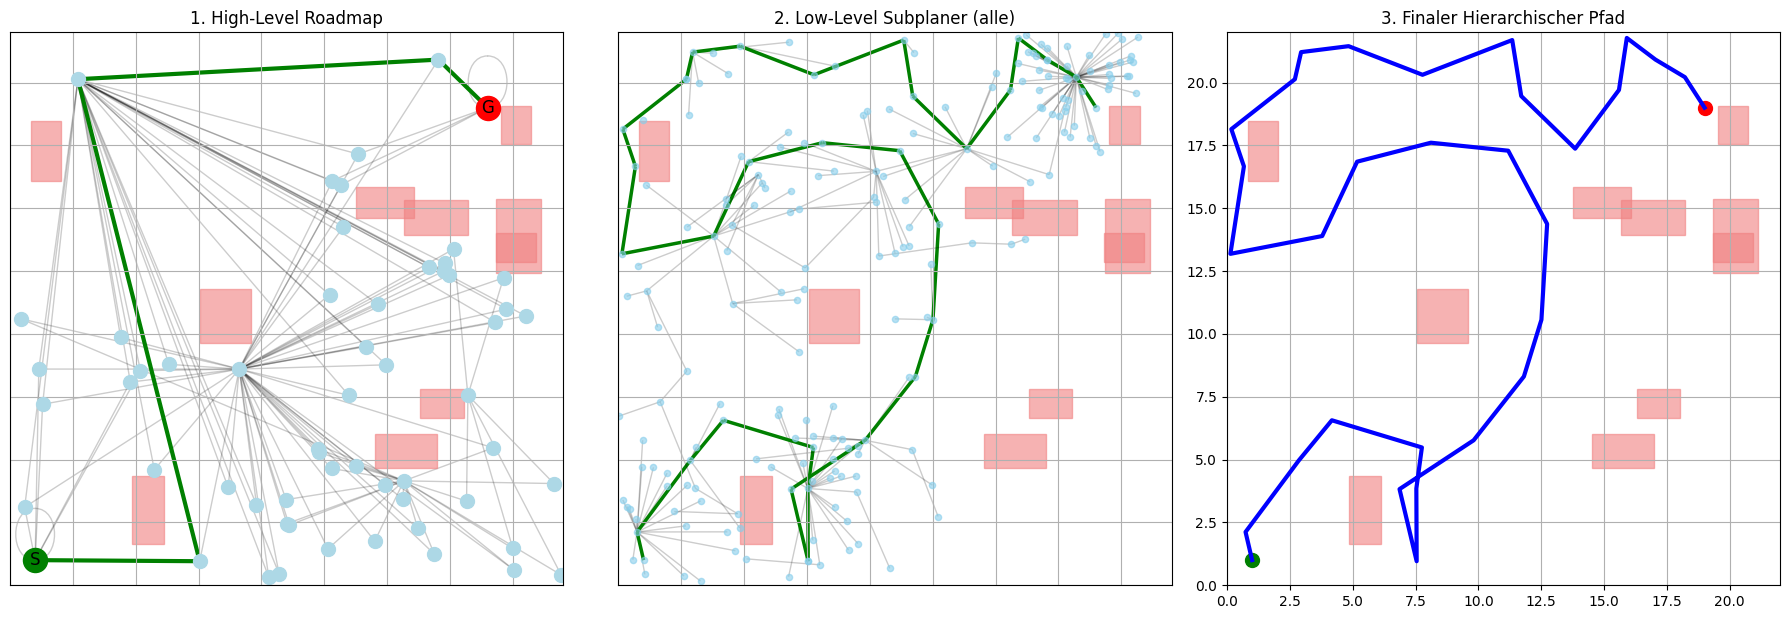


✅ Alle Benchmarks abgeschlossen.


In [4]:
# ---- Beide Varianten durchlaufen ----
all_results = []

# Lazy-Run
lazy_results = run_benchmark("Lazy", config_low_lazy)
lazy_df = pd.DataFrame(lazy_results)
lazy_df.to_csv(os.path.join(results_dir, "Hierarchical-Lazy_results.csv"), index=False)
all_results.extend(lazy_results)

# Basic-Run
basic_results = run_benchmark("Basic", config_low_basic)
basic_df = pd.DataFrame(basic_results)
basic_df.to_csv(os.path.join(results_dir, "Hierarchical-Basic_results.csv"), index=False)
all_results.extend(basic_results)

# Optional: Zusammengefasst
all_df = pd.DataFrame(all_results)
all_df.to_csv(os.path.join(results_dir, "Hierarchical_ALL_results.csv"), index=False)

print("\n✅ Alle Benchmarks abgeschlossen.")

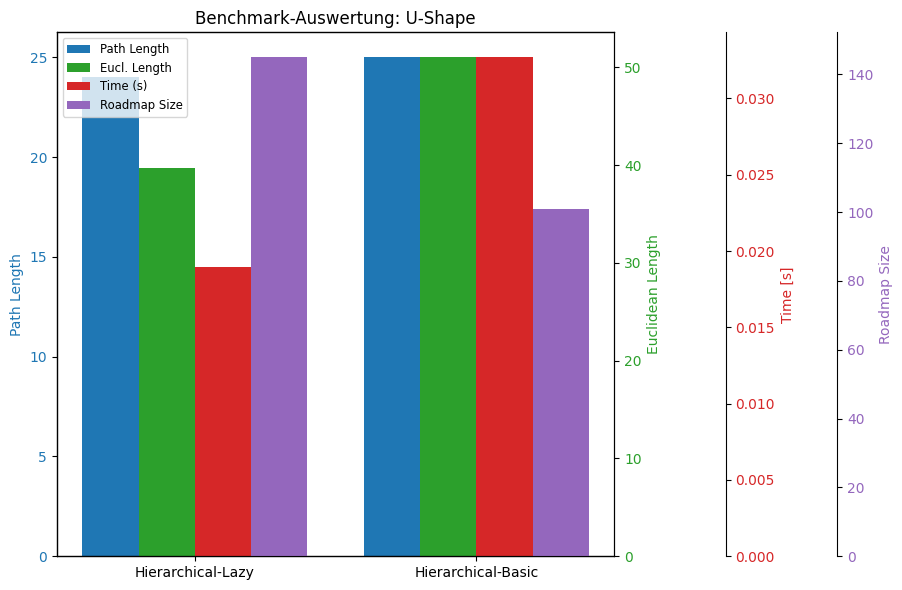

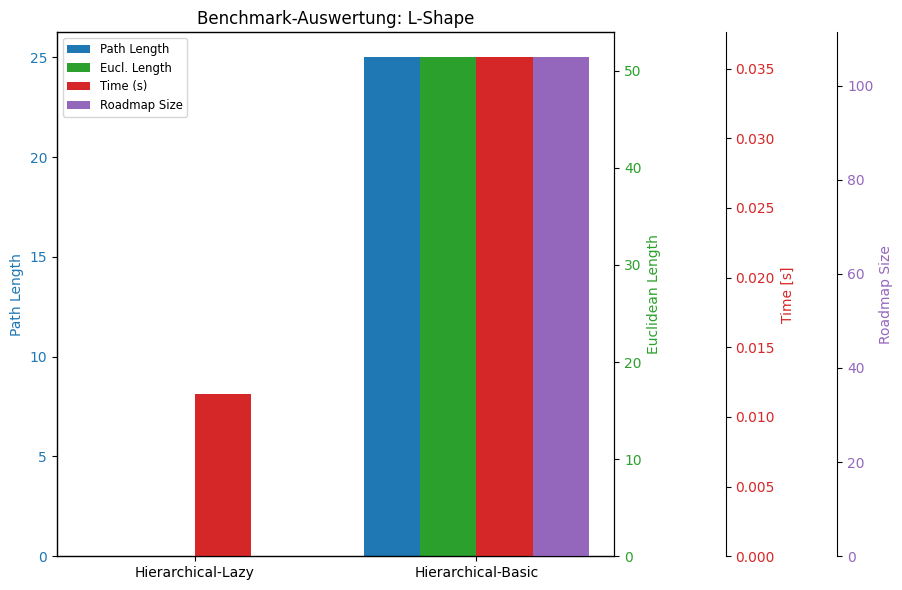

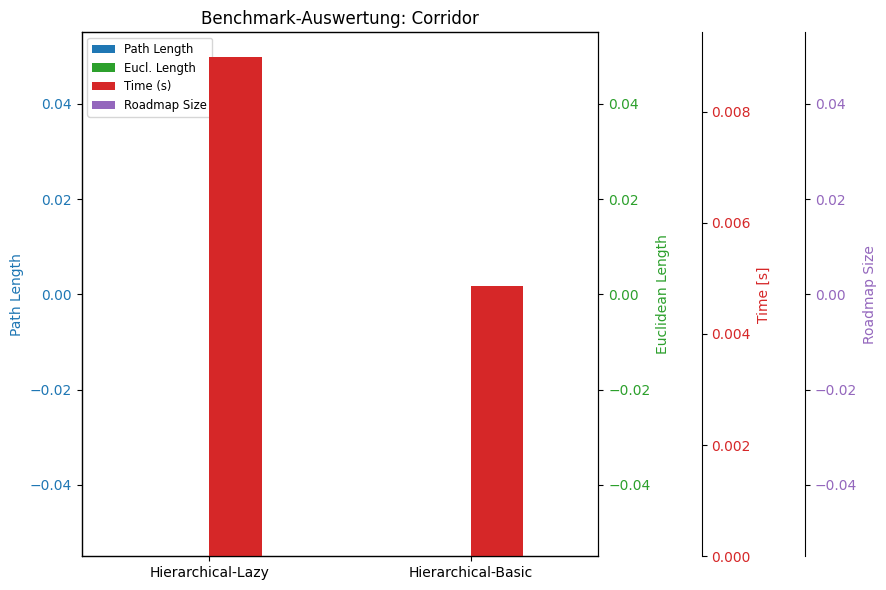

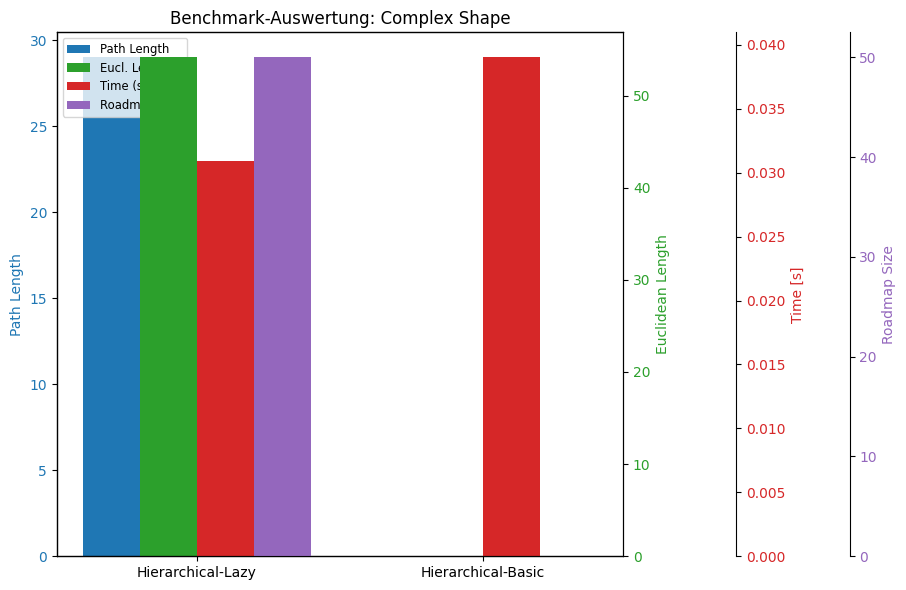

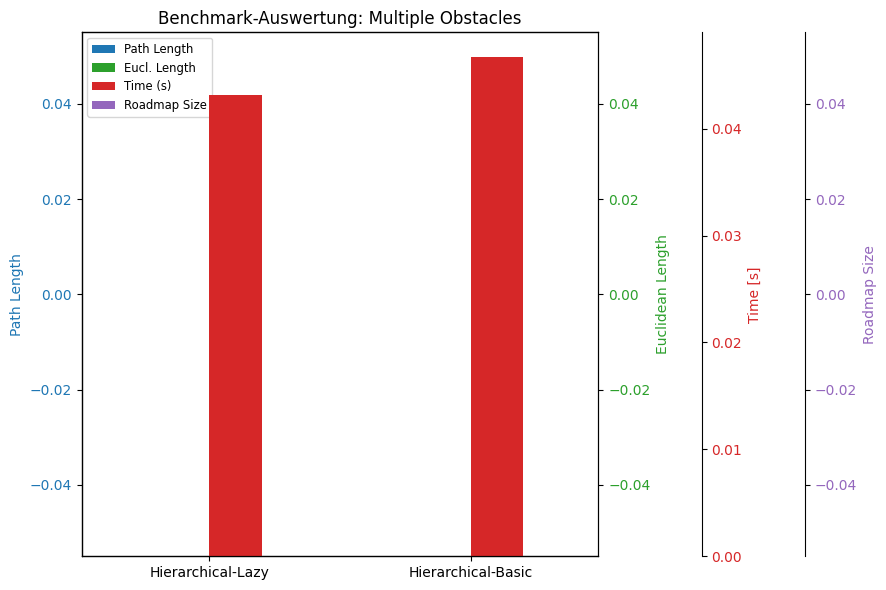

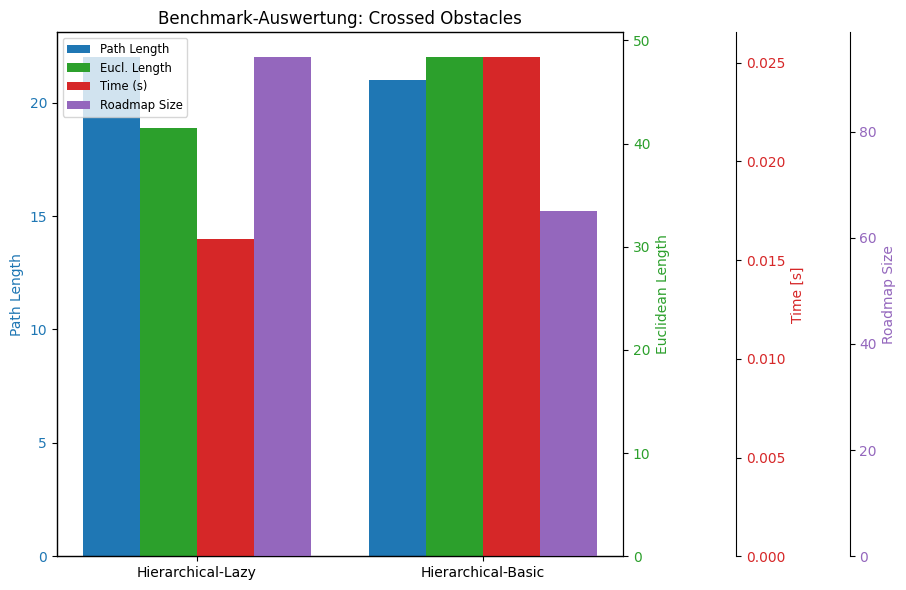

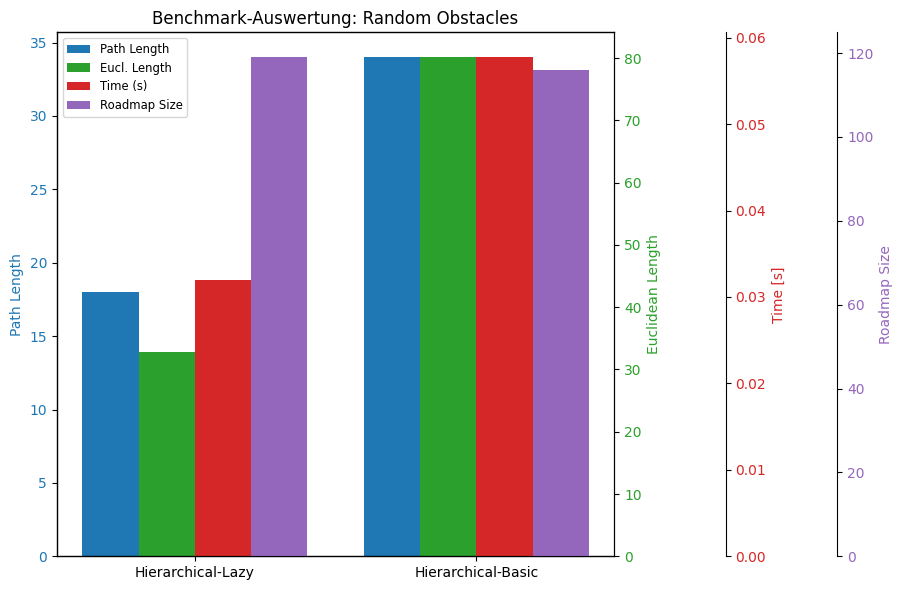

In [5]:
# Visualisierung
result_df = pd.DataFrame(all_results)
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    width = 0.2
    idx = np.arange(len(df))

    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2 * width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3 * width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    ax1.set_xticks(idx + 1.5 * width)
    ax1.set_xticklabels(df["planner"].values)
    ax1.set_title(f"Benchmark-Auswertung: {scene}")

    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()

Globaler Pfad: ['start', 0, 17, 'goal']
Koordinaten des globalen Pfads: [[2.0, 20.0], array([ 2.45285695, 18.62069984]), array([5.79453314, 0.53155417]), [20.0, 2.0]]
Segment 0: [2.0, 20.0] → [ 2.45285695 18.62069984]
→ Lokaler Planner für Segment 0: [2.0, 20.0] → [ 2.45285695 18.62069984]
   Lokale Begrenzung (geclipped): ((np.float64(0.7746887070414297), np.float64(3.6781682470167483)), (np.float64(17.858610148644082), np.float64(20.762089688619405)))
Segment 1: [ 2.45285695 18.62069984] → [5.79453314 0.53155417]
→ Lokaler Planner für Segment 1: [ 2.45285695 18.62069984] → [5.79453314 0.53155417]
   Lokale Begrenzung (geclipped): ((0, np.float64(12.123695046786406)), (np.float64(1.576127005209651), np.float64(17.57612700520965)))
Segment 2: [5.79453314 0.53155417] → [20.0, 2.0]
→ Lokaler Planner für Segment 2: [5.79453314 0.53155417] → [20.0, 2.0]
   Lokale Begrenzung (geclipped): ((np.float64(4.897266569757317), np.float64(20.897266569757317)), (0, np.float64(9.265777086577907)))
✅ 

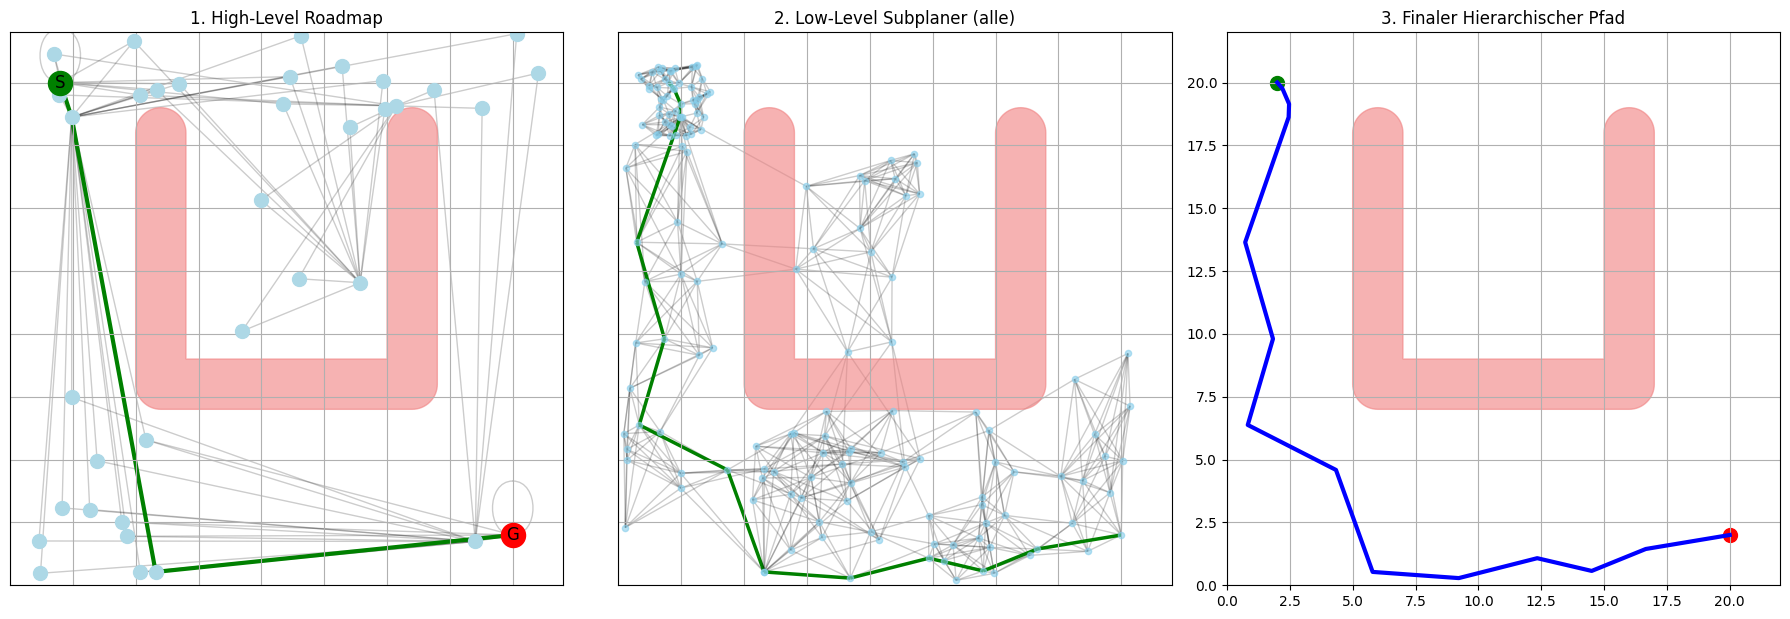

In [7]:
# --- Pfadplanung ---
hier_planner = HierarchicalPlanner(
    scene=scenes[0][1][0],  # Nimm die erste Szene
    limits=scenes[0][1][1],
    GlobalPlannerClass=VisibilityPRM,
    LocalPlannerClass=LazyPRM,  # Oder BasicPRM
    config_global=config_high,
    config_local=config_low_lazy  # Oder config_low_basic
)

start = [list(scenes[0][1][2][0])]
goal = [list(scenes[0][1][2][1])]
path = hier_planner.plan_path(start, goal)
if not path:
    print("❌ Kein Pfad gefunden.")
else:
    print("✅ Pfad gefunden mit", len(path), "Punkten")

    # Korrekte Reihenfolge der Initialisierung für die Visualisierung
    hier_planner.solution_path = path  # Statt final_path
    hier_planner.graph = hier_planner.global_planner.graph  # Verwende direkt den globalen Planer-Graph

    collision_checker = CollisionChecker(hier_planner.scene, hier_planner.limits)
    visualize_hierarchical_planning(hier_planner, collision_checker, hier_planner.config_local)



🔄 Verarbeite Szene: U-Shape
Globaler Pfad: ['start', 0, 20, 'goal']
Koordinaten des globalen Pfads: [[2.0, 20.0], array([ 0.74247405, 14.40904099]), array([5.02313856, 1.70395689]), [20.0, 2.0]]
Segment 0: [2.0, 20.0] → [ 0.74247405 14.40904099]
→ Lokaler Planner für Segment 0: [2.0, 20.0] → [ 0.74247405 14.40904099]
   Lokale Begrenzung (geclipped): ((0, np.float64(7.101873479030301)), (np.float64(11.47388403888618), 22))
Segment 1: [ 0.74247405 14.40904099] → [5.02313856 1.70395689]
→ Lokaler Planner für Segment 1: [ 0.74247405 14.40904099] → [5.02313856 1.70395689]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.882806303566868)), (np.float64(0.05649893935894568), np.float64(16.056498939358946)))
Segment 2: [5.02313856 1.70395689] → [20.0, 2.0]
→ Lokaler Planner für Segment 2: [5.02313856 1.70395689] → [20.0, 2.0]
   Lokale Begrenzung (geclipped): ((np.float64(4.511569280121236), np.float64(20.511569280121236)), (0, np.float64(9.851978444888095)))
✅ Pfad gefunden in Szene: U-S

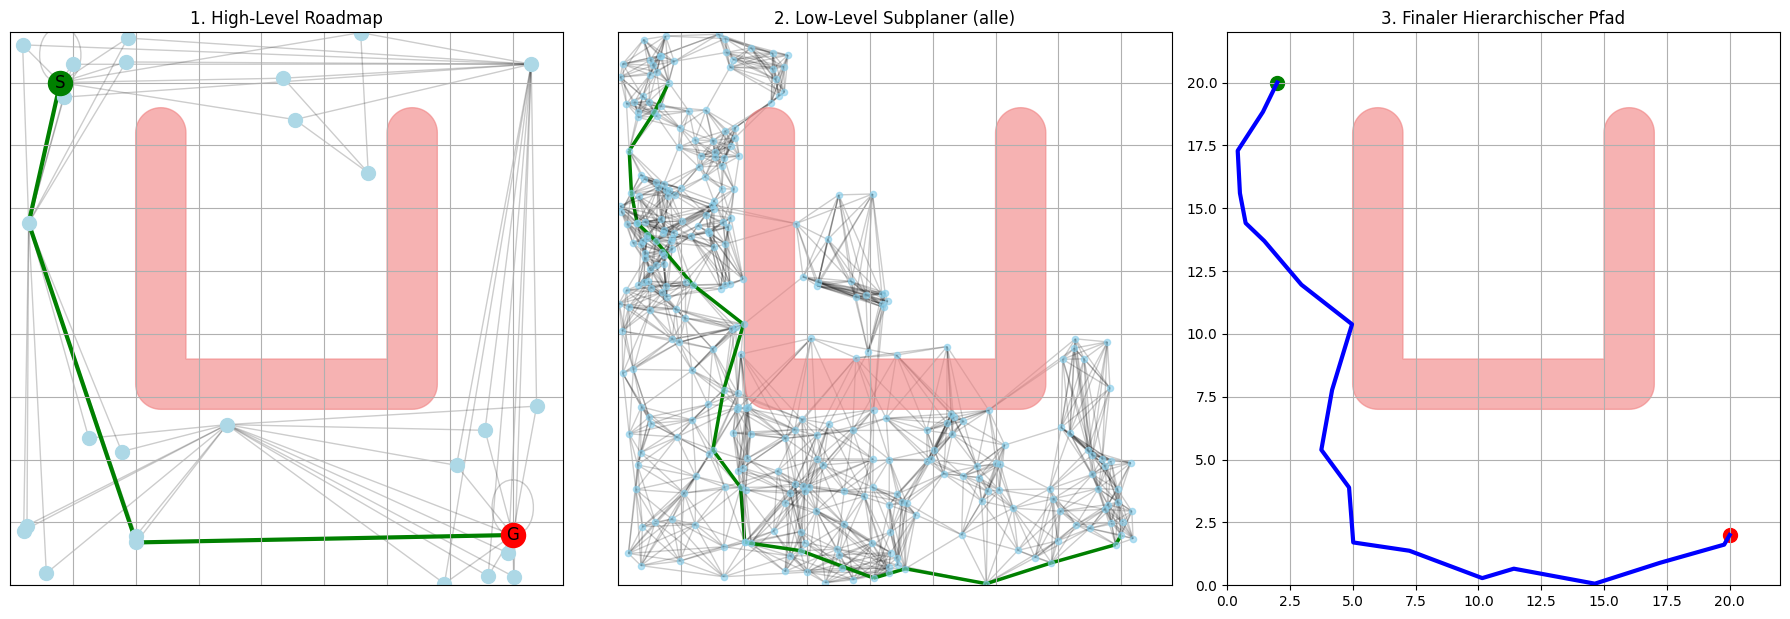


🔄 Verarbeite Szene: L-Shape
Globaler Pfad: ['start', 37, 1, 'goal']
Koordinaten des globalen Pfads: [[2.0, 2.0], array([11.4664636 ,  0.46854646]), array([19.15285483,  9.73229125]), [15.0, 15.0]]
Segment 0: [2.0, 2.0] → [11.4664636   0.46854646]
→ Lokaler Planner für Segment 0: [2.0, 2.0] → [11.4664636   0.46854646]
   Lokale Begrenzung (geclipped): ((0, np.float64(14.733231801569591)), (0, np.float64(9.234273227530059)))
Segment 1: [11.4664636   0.46854646] → [19.15285483  9.73229125]
→ Lokaler Planner für Segment 1: [11.4664636   0.46854646] → [19.15285483  9.73229125]
   Lokale Begrenzung (geclipped): ((np.float64(7.309659218163789), 22), (0, np.float64(13.100418850216968)))
Segment 2: [19.15285483  9.73229125] → [15.0, 15.0]
→ Lokaler Planner für Segment 2: [19.15285483  9.73229125] → [15.0, 15.0]
   Lokale Begrenzung (geclipped): ((np.float64(10.368599244294199), 22), (np.float64(5.658317450386907), np.float64(19.07397379498691)))
✅ Pfad gefunden in Szene: L-Shape, Länge: 20


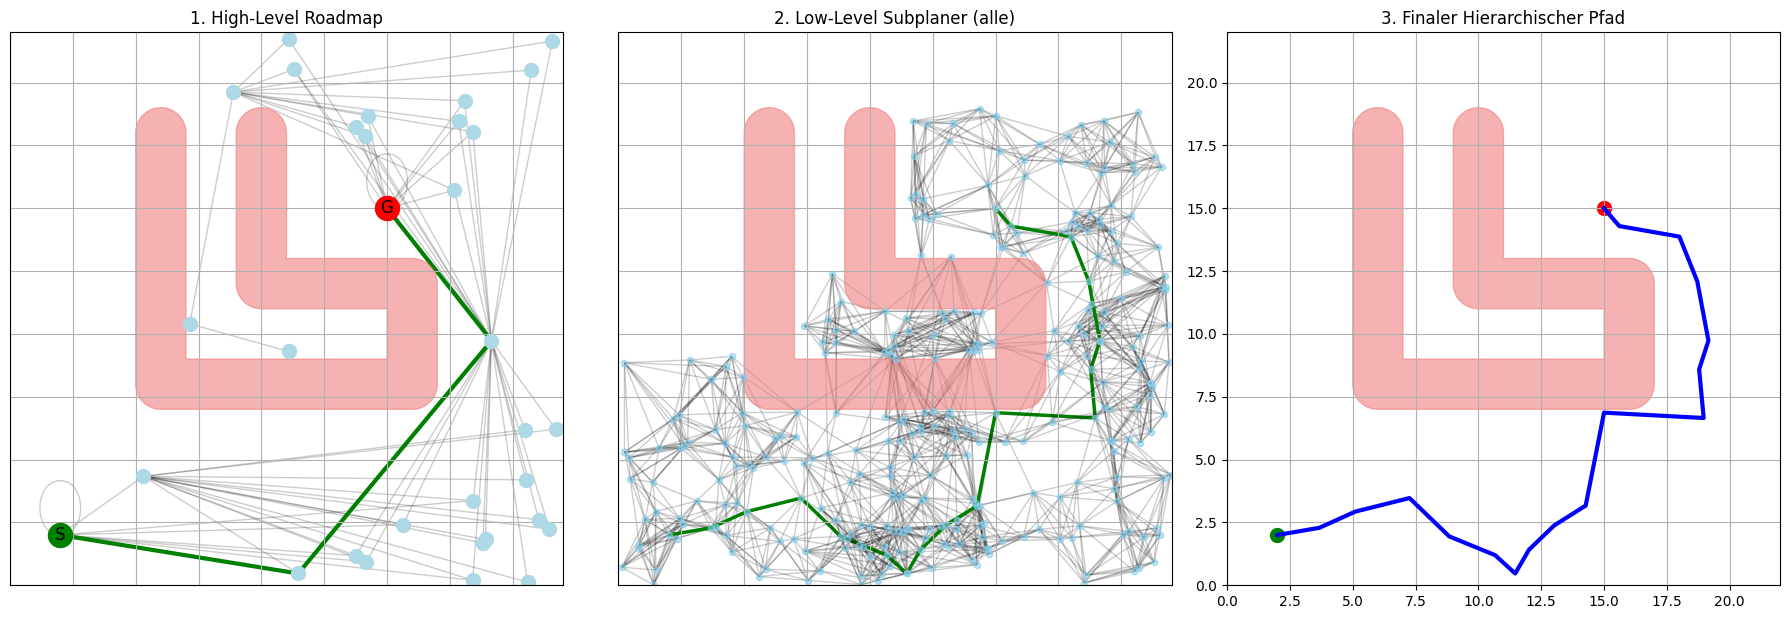


🔄 Verarbeite Szene: Corridor
Kein Pfad im Sichtbarkeitsgraph gefunden.
❌ Kein Pfad gefunden in Szene: Corridor

🔄 Verarbeite Szene: Complex Shape
Globaler Pfad: ['start', 4, 30, 6, 15, 1, 'goal']
Koordinaten des globalen Pfads: [[5.0, 5.0], array([ 4.09462469, 11.9751447 ]), array([ 4.02732946, 19.72476845]), array([20.03658389, 20.74492026]), array([16.83976683, 17.27935573]), array([17.79669166,  3.75901799]), [17.5, 5.0]]
Segment 0: [5.0, 5.0] → [ 4.09462469 11.9751447 ]
→ Lokaler Planner für Segment 0: [5.0, 5.0] → [ 4.09462469 11.9751447 ]
   Lokale Begrenzung (geclipped): ((0, np.float64(11.58097057529988)), (np.float64(1.4539141234994188), np.float64(15.521230579145449)))
Segment 1: [ 4.09462469 11.9751447 ] → [ 4.02732946 19.72476845]
→ Lokaler Planner für Segment 1: [ 4.09462469 11.9751447 ] → [ 4.02732946 19.72476845]
   Lokale Begrenzung (geclipped): ((0, np.float64(11.81089300887658)), (np.float64(8.10004064720107), 22))
Segment 2: [ 4.02732946 19.72476845] → [20.03658389 

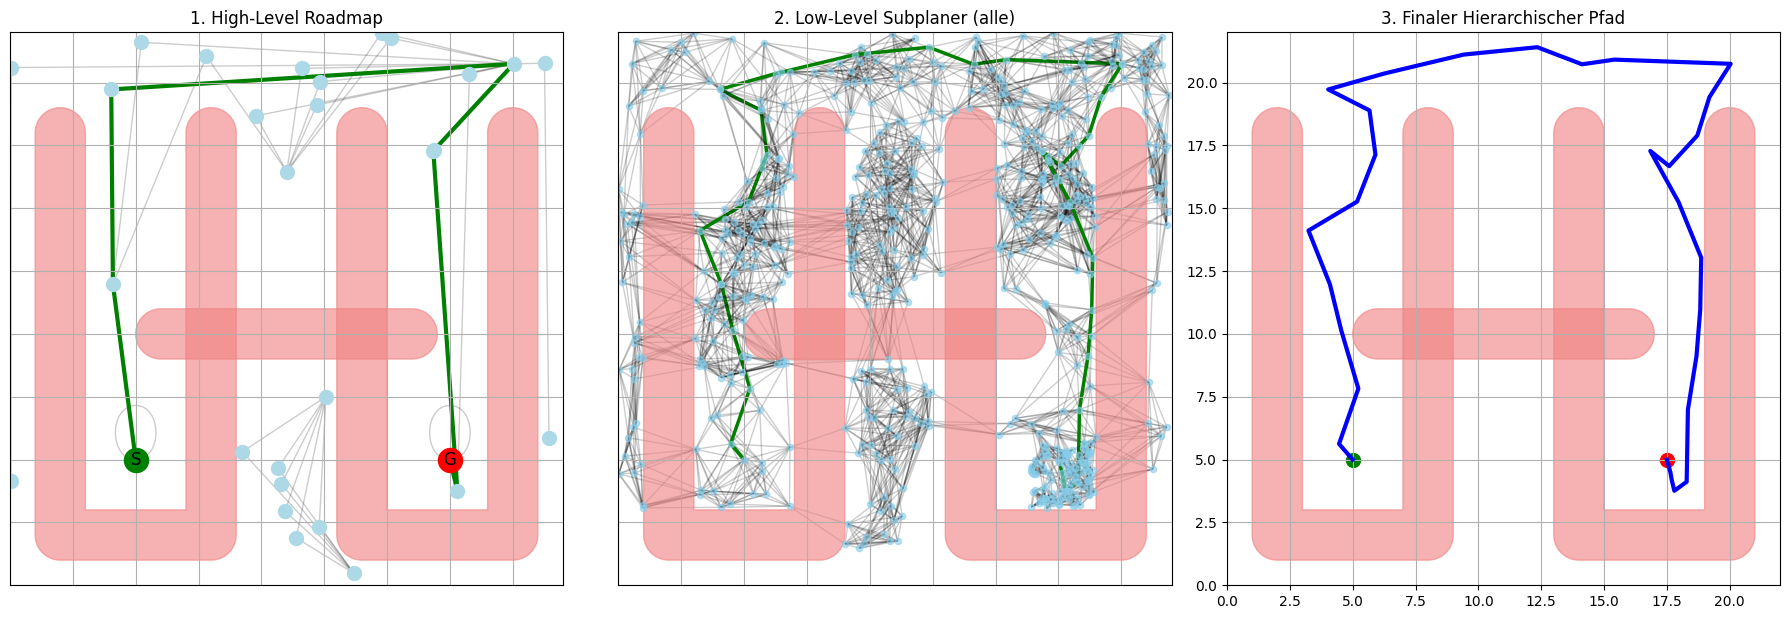


🔄 Verarbeite Szene: Multiple Obstacles
Globaler Pfad: ['start', 14, 25, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([1.03481055, 3.04443567]), array([ 1.34715122, 20.81122785]), [5.0, 21.0]]
Segment 0: [1.0, 1.0] → [1.03481055 3.04443567]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [1.03481055 3.04443567]
   Lokale Begrenzung (geclipped): ((0, np.float64(3.0621372806459135)), (0, np.float64(4.066949842665345)))
Segment 1: [1.03481055 3.04443567] → [ 1.34715122 20.81122785]
→ Lokaler Planner für Segment 1: [1.03481055 3.04443567] → [ 1.34715122 20.81122785]
   Lokale Begrenzung (geclipped): ((0, np.float64(9.19098088244253)), (np.float64(3.9278317579040447), np.float64(19.927831757904045)))
❌ Keine lokale Verbindung zwischen [1.03481055 3.04443567] und [ 1.34715122 20.81122785].
❌ Kein Pfad gefunden in Szene: Multiple Obstacles

🔄 Verarbeite Szene: Crossed Obstacles
Globaler Pfad: ['start', 2, 8, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([17.77454554, 

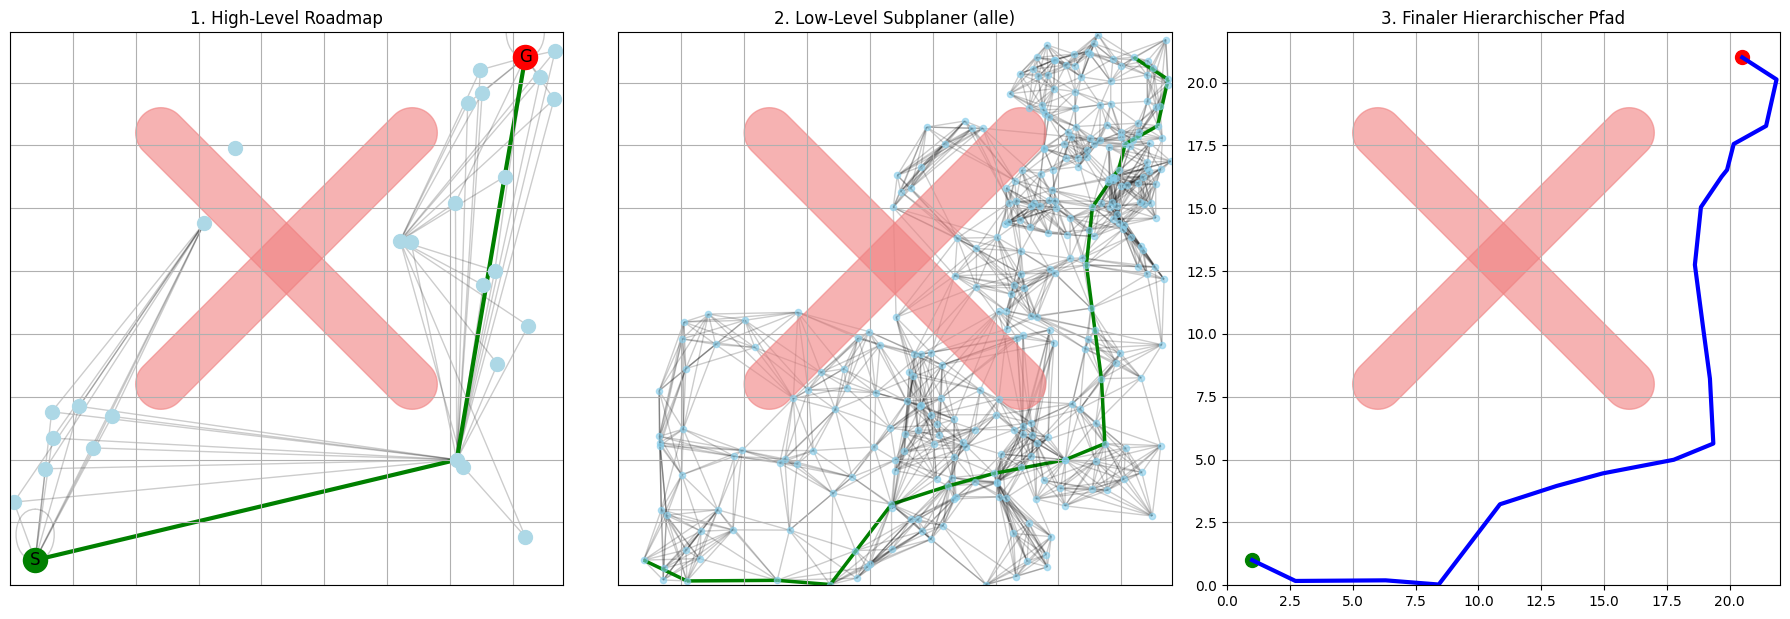


🔄 Verarbeite Szene: Random Obstacles
Globaler Pfad: ['start', 116, 0, 7, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([3.83364265, 0.01576543]), array([10.34311977,  3.99972235]), array([14.7101451 , 20.72411941]), [19.0, 19.0]]
Segment 0: [1.0, 1.0] → [3.83364265 0.01576543]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [3.83364265 0.01576543]
   Lokale Begrenzung (geclipped): ((0, np.float64(5.41652937632602)), (0, np.float64(3.5075907654073495)))
Segment 1: [3.83364265 0.01576543] → [10.34311977  3.99972235]
→ Lokaler Planner für Segment 1: [3.83364265 0.01576543] → [10.34311977  3.99972235]
   Lokale Begrenzung (geclipped): ((0, np.float64(14.720235836101464)), (0, np.float64(9.639598515492729)))
Segment 2: [10.34311977  3.99972235] → [14.7101451  20.72411941]
→ Lokaler Planner für Segment 2: [10.34311977  3.99972235] → [14.7101451  20.72411941]
   Lokale Begrenzung (geclipped): ((np.float64(4.526632436026254), np.float64(20.526632436026254)), (np.float64(4.361920878

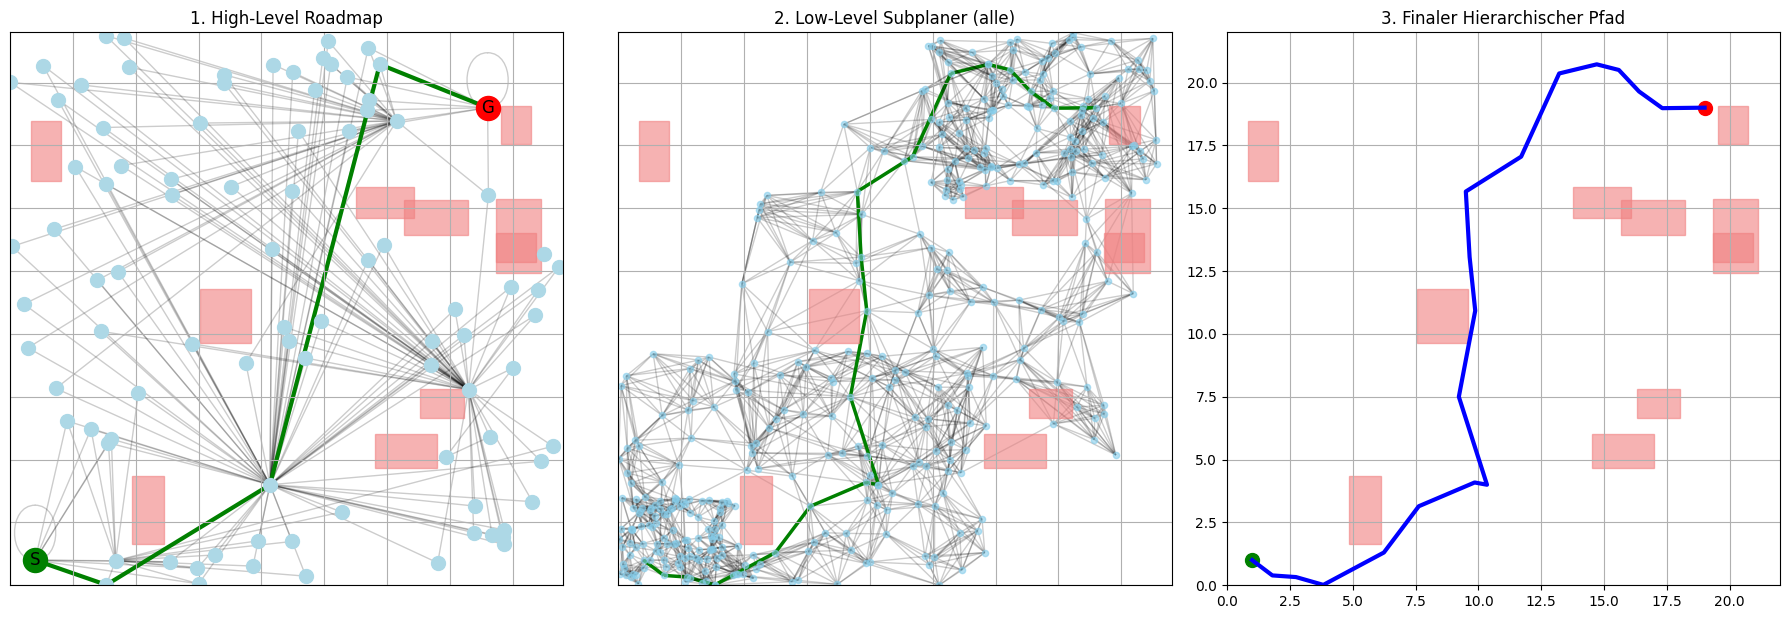

In [8]:
# --- Jede Szene durchlaufen ---
config_low = {
    "initialRoadmapSize": 100,
    "kNearest": 10,
    "maxIterations": 20,
    "updateRoadmapSize": 50
}
for name, (scene, limits, (start_tuple, goal_tuple)) in scenes:
    print(f"\n🔄 Verarbeite Szene: {name}")

    # Start- und Zielposition ins passende Format bringen
    start = [list(start_tuple)]
    goal = [list(goal_tuple)]

    # Kollisionserkennung
    collision_checker = CollisionChecker(scene, limits)

    # Planer initialisieren
    hier_planner = HierarchicalPlanner(
        scene=scene,
        limits=limits,
        GlobalPlannerClass=VisibilityPRM,
        LocalPlannerClass=LazyPRM,
        config_global=config_high,
        config_local=config_low
    )

    # Pfadplanung
    path = hier_planner.plan_path(start, goal)
    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {name}")
        continue
    else:
        print(f"✅ Pfad gefunden in Szene: {name}, Länge: {len(path)}")

    # Visualisierung vorbereiten (optional, kann deaktiviert werden)
    hier_planner.solution_path = path
    hier_planner.graph = hier_planner.global_planner.graph
    visualize_hierarchical_planning(hier_planner, collision_checker, config_low)

    # Alternativ: Ergebnisse speichern oder zusammenfassen